
# Changing MLP Architecture and Fitting

This example is nearly identical to the Synthetic Data fit, however we use
a different neural network architecture in hopes of obtaining a better spectra fitting.
The same set-up using the Mann model under the Kaimal spectra is used here as in other synthetic
data fitting examples. The only difference here is in the neural network architecture.
Although certain combinations of activation functions, such as ``GELU`` result in considerably
improved spectra fitting and terminal loss values, the resulting eddy lifetime functions are
usually non-physical.

See again the [original DRD paper](https://arxiv.org/abs/2107.11046).


## Import packages

First, we import the packages we need for this example. Additionally, we choose to use
CUDA if it is available.



In [1]:
import torch
import torch.nn as nn

from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

Set up physical parameters and domain associated with the Kaimal spectrum. We perform the spectra fitting over the $k_1$ space $[10^{{-1}}, 10^2]$
with 20 points.



In [2]:
zref = 40  # reference height
ustar = 1.773  # friction velocity

# Scales associated with Kaimal spectrum
L = 0.59 * zref  # length scale
Gamma = 3.9  # time scale
sigma = 3.2 * ustar**2.0 / zref ** (2.0 / 3.0)  # energy spectrum scale

print(f"Physical Parameters: {L,Gamma,sigma}")

k1 = torch.logspace(-1, 2, 20) / zref

Physical Parameters: (23.599999999999998, 3.9, 0.8600574364289042)


%%
Now, we construct our ``CalibrationProblem``.

Compared to the first Synthetic Fit example, as noted already, we are using
a more complicated neural network architecture. This time, specifically, our
network will have 4 layers of width 10, 20, 20, 10 respectively, and we
use both ``GELU`` and ``RELU`` activations. We have
prescribed more Wolfe iterations.
Finally, this task is considerably more difficult than before since the exponent of
the eddy lifetime function $\nu$ is to be learned. Much more training
may be necessary to obtain a close fit to the eddy lifetime function. Interestingly,
learning this parameter results in models that more accurately describe the spectra of
Mann turbulence than using the Mann model itself.



In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=4,
        # Specifying the activations is done similarly.
        hidden_layer_sizes=[10, 20, 20, 10],
        activations=[nn.ReLU(), nn.GELU(), nn.GELU(), nn.ReLU()],
    ),
    prob_params=ProblemParameters(nepochs=25, wolfe_iter_count=20),
    loss_params=LossParameters(alpha_pen2=1.0, beta_reg=1.0e-5),
    phys_params=PhysicalParameters(
        L=L, Gamma=Gamma, sigma=sigma, ustar=ustar, domain=k1
    ),
    logging_directory="runs/synthetic_fit_deep_arch",
    device=device,
)

## Data Generation
In the following cell, we construct our $k_1$ data points grid and
generate the values. ``Data`` will be a tuple ``(<data points>, <data values>)``.
It is worth noting that the second element of each tuple in ``DataPoints`` is the
corresponding reference height, which we have chosen to be uniformly `zref`.



In [4]:
Data = OnePointSpectraDataGenerator(data_points=k1, zref=zref, ustar=ustar).Data

## Training
Now, we fit our model. ``CalibrationProblem.calibrate()`` takes the tuple ``Data``
which we just constructed and performs a typical training loop.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

pb.print_calibrated_params()

Initial loss: 0.045089010235689016


  0%|                                                                         | 0/25 [00:00<?, ?it/s]

  4%|██▌                                                              | 1/25 [00:06<02:24,  6.02s/it]

  8%|█████▏                                                           | 2/25 [00:10<01:52,  4.91s/it]

 12%|███████▊                                                         | 3/25 [00:14<01:38,  4.48s/it]

 16%|██████████▍                                                      | 4/25 [00:18<01:30,  4.29s/it]

 20%|█████████████                                                    | 5/25 [00:22<01:23,  4.19s/it]

 24%|███████████████▌                                                 | 6/25 [00:26<01:19,  4.17s/it]

 28%|██████████████████▏                                              | 7/25 [00:30<01:14,  4.11s/it]

 32%|████████████████████▊                                            | 8/25 [00:34<01:09,  4.08s/it]

 36%|███████████████████████▍                                         | 9/25 [00:38<01:05,  4.10s/it]

 40%|█████████████████████████▌                                      | 10/25 [00:42<01:00,  4.07s/it]

 44%|████████████████████████████▏                                   | 11/25 [00:46<00:57,  4.09s/it]

 48%|██████████████████████████████▋                                 | 12/25 [00:50<00:53,  4.11s/it]

 52%|█████████████████████████████████▎                              | 13/25 [00:54<00:48,  4.07s/it]

 56%|███████████████████████████████████▊                            | 14/25 [00:58<00:45,  4.09s/it]

 60%|██████████████████████████████████████▍                         | 15/25 [01:02<00:41,  4.11s/it]

 64%|████████████████████████████████████████▉                       | 16/25 [01:06<00:36,  4.07s/it]

 68%|███████████████████████████████████████████▌                    | 17/25 [01:10<00:32,  4.04s/it]

 72%|██████████████████████████████████████████████                  | 18/25 [01:15<00:28,  4.12s/it]

 76%|████████████████████████████████████████████████▋               | 19/25 [01:19<00:24,  4.08s/it]

 80%|███████████████████████████████████████████████████▏            | 20/25 [01:23<00:20,  4.14s/it]

 84%|█████████████████████████████████████████████████████▊          | 21/25 [01:27<00:16,  4.14s/it]

 88%|████████████████████████████████████████████████████████▎       | 22/25 [01:31<00:12,  4.14s/it]

 92%|██████████████████████████████████████████████████████████▉     | 23/25 [01:35<00:08,  4.14s/it]

 96%|█████████████████████████████████████████████████████████████▍  | 24/25 [01:40<00:04,  4.18s/it]

100%|████████████████████████████████████████████████████████████████| 25/25 [01:44<00:00,  4.12s/it]

100%|████████████████████████████████████████████████████████████████| 25/25 [01:44<00:00,  4.17s/it]

Spectra fitting concluded with final loss: 0.00258780039475945
Optimal calibrated L     :  23.6964 
Optimal calibrated Gamma :   3.6677 
Optimal calibrated sigma :   0.8157 


## Plotting
Lastly, we'll use built-in plotting utilities to see the fit result.



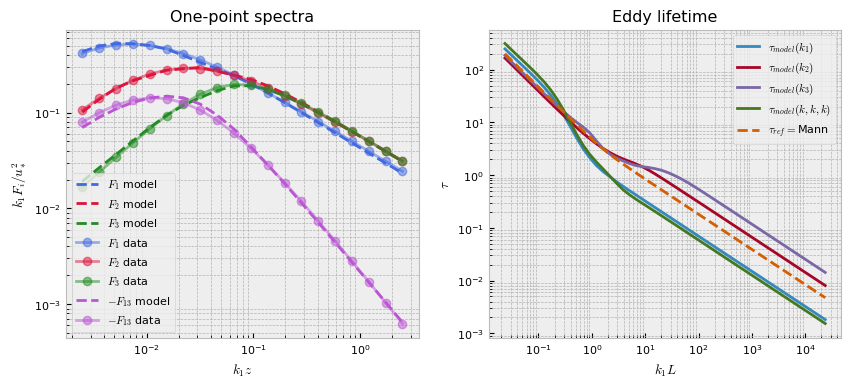

In [6]:
pb.plot()

This plots the loss function terms as specified, each multiplied by the
respective coefficient hyperparameter. The training logs can be accessed from the logging directory
with Tensorboard utilities, but we also provide a simple internal utility for a single
training log plot.



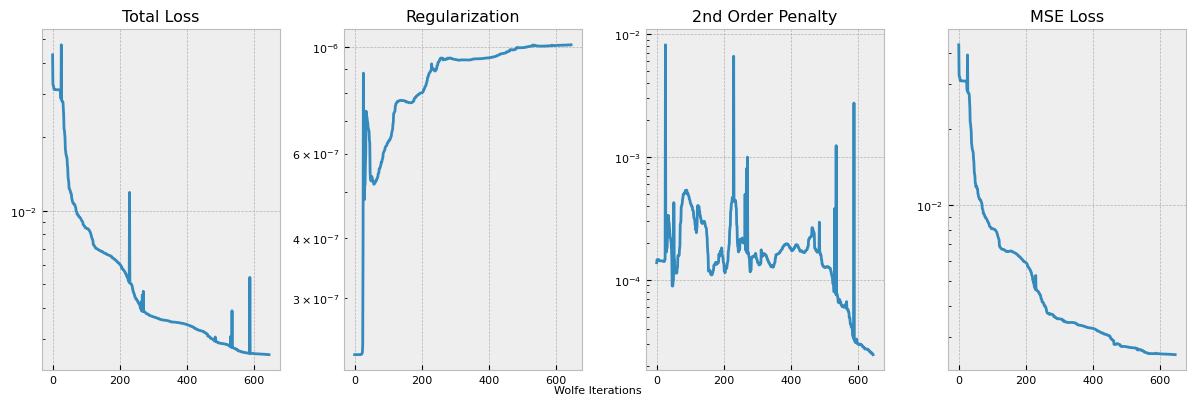

In [7]:
pb.plot_losses(run_number=0)